# פרויקט חיזוי מחיר שכירות דירה בת"א - למידת מכונה

### Yuval Lebel 
### Maor Weissmann 


### פונקציית עיבוד נתונים - prepare_data

In [1]:
# 🧠 תא 1: פונקציות הכנה
import pandas as pd
import numpy as np
import pickle
import re
from sklearn.preprocessing import OneHotEncoder


def prepare_data(df, dataset_type='train'):

    def fix_distance_km(val):
        # בדיקה אם הערך ריק או None
        if pd.isna(val) or val == '' or val is None:
            return 1.0
        
        try:
            val_str = str(val).replace(',', '').strip().lower()
            match = re.search(r'(\d+(\.\d+)?)', val_str)
            if not match:
                return 1.0
            num = float(match.group(1))
            if 'ק"מ' in val_str or 'km' in val_str or 'kilometer' in val_str:
                return num
            if 'מטר' in val_str or 'meter' in val_str or 'm' in val_str:
                return num / 1000
            return num / 1000 if num > 20 else num
        except:
            return 1.0
            
    def fix_floor_values(val):
        if pd.isna(val):
            return 0.0
        val_str = str(val).strip().lower()
        
        # זיהוי קרקע/מרתף
        if any(word in val_str for word in ["קרקע", "ground", "basement", "מרתף"]):
            return 0.0
        
        # זיהוי מרתפים עם מספרים שליליים
        if "מרתף" in val_str or "basement" in val_str:
            match = re.search(r'-?\d+', val_str)
            if match:
                return float(match.group())
        
        # חיפוש מספר רגיל
        match = re.search(r'\d+', val_str)
        if match:
            return float(match.group())
        
        return 0.0        
    
    
    is_train = dataset_type == 'train'
    df = df.copy()
    df['distance_from_center'] = df['distance_from_center'].apply(fix_distance_km)
    df['floor'] = df['floor'].apply(fix_floor_values)
    df['garden_area'] = df['garden_area'].fillna(0)
    df['monthly_arnona'] = df['monthly_arnona'].fillna(df.groupby(['neighborhood', 'room_num'])['monthly_arnona'].transform('mean')
                                                      ).fillna(df.groupby('neighborhood')['monthly_arnona'].transform('mean')
                                                              ).fillna(df['monthly_arnona'].mean())
    df['building_tax'] = df['building_tax'].fillna(df.groupby(['neighborhood', 'room_num'])['building_tax'].transform('mean')
                                                  ).fillna(df.groupby('neighborhood')['building_tax'].transform('mean')
                                                          ).fillna(df['building_tax'].mean())
    
    
    if is_train:
        if 'price' in df.columns:
            df = df[(df['price'] >= 1000) & (df['price'] <= 100000)]
        if 'area' in df.columns:
            df = df[df['area'] <= 1000]
        if 'garden_area' in df.columns:
            df = df[df['garden_area'] <= 500]
        if 'distance_from_center' in df.columns:
            df = df[df['distance_from_center'] <= 20000]
        if 'monthly_arnona' in df.columns:
            df = df[df['monthly_arnona'] <= 3000]
        if 'building_tax' in df.columns:
            df = df[df['building_tax'] <= 3000]


    if 'price' in df.columns and not is_train:
        df = df.drop(columns=['price'])

    if 'property_type' in df.columns:
        df['property_type'] = df['property_type'].astype(str).str.strip()
        invalid_types = ['כללי', 'חניה', 'סאבלט', 'מרתף/פרטר']
        if is_train:
            df = df[~df['property_type'].isin(invalid_types)]

    if 'neighborhood' in df.columns:
        df['neighborhood'] = df['neighborhood'].astype(str).str.strip()
        def is_invalid_neighborhood(name):
            if not isinstance(name, str): return True
            name = name.strip()
            if name in ['כללי', 'אחר', 'unknown', '', 'nan', 'NaN']: return True
            if re.fullmatch(r'[A-Za-z\s\-]+', name): return True
            return False
        if is_train:
            df = df[~df['neighborhood'].apply(is_invalid_neighborhood)]

    numeric_cols = ['room_num', 'floor', 'area', 'garden_area',
                    'num_of_payments', 'monthly_arnona', 'building_tax',
                    'total_floors', 'num_of_images']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if all(col in df.columns for col in ['monthly_arnona', 'area', 'neighborhood']):
        df['arnona_per_sqm'] = df['monthly_arnona'] / df['area']
        avg_arnona_per_sqm = df.groupby('neighborhood')['arnona_per_sqm'].mean()
        def fill_arnona(row):
            if pd.isna(row['monthly_arnona']):
                avg = avg_arnona_per_sqm.get(row['neighborhood'], None)
                return avg * row['area'] if avg else row['monthly_arnona']
            return row['monthly_arnona']
        df['monthly_arnona'] = df.apply(fill_arnona, axis=1)
        df.drop(columns='arnona_per_sqm', inplace=True)

    if is_train:
        medians = {col: df[col].median() for col in numeric_cols}
        with open('feature_medians.pkl', 'wb') as f:
            pickle.dump(medians, f)
    else:
        with open('feature_medians.pkl', 'rb') as f:
            medians = pickle.load(f)
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(medians.get(col, 0))

    def enrich_description(df):
        keywords = {
            "has_parking": "חניה",
            "has_storage": "מחסן",
            "has_safe_room": "ממ\"ד",
            "has_balcony": "מרפסת",
            "is_renovated": "משופץ",
            "is_furnished": "מרוהט"
        }
        if 'description' in df.columns:
            for col, keyword in keywords.items():
                if col not in df.columns or df[col].isna().all():
                    df[col] = df['description'].str.contains(keyword, na=False).astype(int)
        return df
    df = enrich_description(df)

    binary_cols = ['has_parking', 'has_storage', 'elevator', 'ac', 'handicap',
                   'has_bars', 'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({'כן': 1, 'לא': 0, 'Yes': 1, 'No': 0,
                                   'true': 1, 'false': 0, '1': 1, '0': 0}).fillna(0).astype(int)

    df['garden_area'] = df.get('garden_area', 0).fillna(0)
    if 'room_num' in df.columns and 'area' in df.columns:
        df['area_per_room'] = np.where(df['room_num'] > 0, df['area'] / df['room_num'], df['area'])

    def floor_score(row):
        if pd.isna(row['floor']) or pd.isna(row['total_floors']): return 1
        if row['floor'] == 0: return 2
        elif row['floor'] == row['total_floors']: return 1.5
        else: return 1
    df['floor_score'] = df.apply(floor_score, axis=1)

    if 'neighborhood' in df.columns:
        if is_train and 'price' in df.columns:
            hood_avg = df.groupby('neighborhood')['price'].mean().to_dict()
            with open('neighborhood_prices.pkl', 'wb') as f:
                pickle.dump(hood_avg, f)
        else:
            try:
                with open('neighborhood_prices.pkl', 'rb') as f:
                    hood_avg = pickle.load(f)
            except:
                hood_avg = {}
        general_avg = np.mean(list(hood_avg.values())) if hood_avg else 5000
        df['neighborhood_price_level'] = df['neighborhood'].map(hood_avg).fillna(general_avg)

    cat_cols = ['property_type']
    df[cat_cols] = df[cat_cols].astype(str).fillna("missing")

    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    if is_train:
        encoded = ohe.fit_transform(df[cat_cols])
        with open("ohe_encoder.pkl", "wb") as f:
            pickle.dump(ohe, f)
    else:
        with open("ohe_encoder.pkl", "rb") as f:
            ohe = pickle.load(f)
        encoded = ohe.transform(df[cat_cols])

    encoded_df = pd.DataFrame(encoded, index=df.index, columns=ohe.get_feature_names_out(cat_cols))
    df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

    return df.select_dtypes(include=[np.number])


def advanced_feature_engineering_for_trees(df):
    print("🔧 מוסיף תכונות מתקדמות...")
    original_cols = len(df.columns)

    if 'area' in df.columns:
        df['size_tiny'] = (df['area'] < 50).astype(int)
        df['size_small'] = ((df['area'] >= 50) & (df['area'] < 80)).astype(int)
        df['size_medium'] = ((df['area'] >= 80) & (df['area'] < 120)).astype(int)
        df['size_large'] = ((df['area'] >= 120) & (df['area'] < 200)).astype(int)
        df['size_huge'] = (df['area'] >= 200).astype(int)
        df['area_sqrt'] = np.sqrt(df['area'])
        df['area_log'] = np.log1p(df['area'])

    if 'room_num' in df.columns:
        df['studio'] = (df['room_num'] <= 1).astype(int)
        df['small_apt'] = (df['room_num'] == 2).astype(int)
        df['medium_apt'] = (df['room_num'] == 3).astype(int)
        df['large_apt'] = (df['room_num'] == 4).astype(int)
        df['huge_apt'] = (df['room_num'] >= 5).astype(int)

    if 'floor' in df.columns and 'total_floors' in df.columns:
        df['ground_floor'] = (df['floor'] == 0).astype(int)
        df['top_floor'] = (df['floor'] == df['total_floors']).astype(int)
        df['middle_floors'] = ((df['floor'] > 0) & (df['floor'] < df['total_floors'])).astype(int)
        df['floor_ratio'] = df['floor'] / (df['total_floors'] + 1)
        df['high_floor'] = (df['floor_ratio'] > 0.7).astype(int)
        df['low_floor'] = (df['floor_ratio'] < 0.3).astype(int)

    if 'monthly_arnona' in df.columns and 'area' in df.columns:
        df['arnona_per_sqm'] = df['monthly_arnona'] / (df['area'] + 1)
        df['high_arnona'] = (df['arnona_per_sqm'] > df['arnona_per_sqm'].median()).astype(int)
        df['low_arnona'] = (df['arnona_per_sqm'] < df['arnona_per_sqm'].quantile(0.25)).astype(int)

    if 'neighborhood_price_level' in df.columns:
        q25, q50, q75 = df['neighborhood_price_level'].quantile([0.25, 0.5, 0.75])
        df['luxury_area'] = (df['neighborhood_price_level'] > q75).astype(int)
        df['premium_area'] = ((df['neighborhood_price_level'] > q50) & (df['neighborhood_price_level'] <= q75)).astype(int)
        df['budget_area'] = (df['neighborhood_price_level'] < q25).astype(int)

    if 'area' in df.columns and 'room_num' in df.columns:
        df['spacious_rooms'] = (df['area_per_room'] > df['area_per_room'].median()).astype(int)
        df['cramped_rooms'] = (df['area_per_room'] < df['area_per_room'].quantile(0.25)).astype(int)
        df['area_room_product'] = df['area'] * df['room_num']
        df['area_squared'] = df['area'] ** 2

    new_cols = len(df.columns)
    print(f"✅ נוספו {new_cols - original_cols} תכונות חדשות")
    print(f"📊 סה\"כ תכונות: {new_cols}")
    return df


### בניית מודלים: Elastic Net,DecisionTree,RandomForest + השוואת ביצועים

📊 טוען ומעבד נתונים...
📊 גודל הדאטה המקורי: (788, 26)
📊 גודל הדאטה לאחר prepare_data: (730, 41)
🔧 מאמן מודל ElasticNet...
💾 ElasticNet נשמר.
🔧 מוסיף תכונות מתקדמות...
✅ נוספו 28 תכונות חדשות
📊 סה"כ תכונות: 68

🔍 השוואת מודלים:
ElasticNet - RMSE: 7036.51, R²: 0.092
DecisionTree - RMSE: 7044.41, R²: 0.090
RandomForest - RMSE: 6829.32, R²: 0.145

🎯 ElasticNet פיצ'רים חשובים:
floor                       729.564772
area                        417.688118
neighborhood_price_level    372.541956
total_floors                337.807760
building_tax                320.430044
dtype: float64

🎯 DecisionTree פיצ'רים חשובים:
area_log                    0.444053
area_squared                0.180576
neighborhood_price_level    0.179189
building_tax                0.074587
area_sqrt                   0.043001
dtype: float64

🎯 RandomForest פיצ'רים חשובים:
area_sqrt               0.175171
area_log                0.160616
area_squared            0.146698
area                    0.118611
distance_from_cente

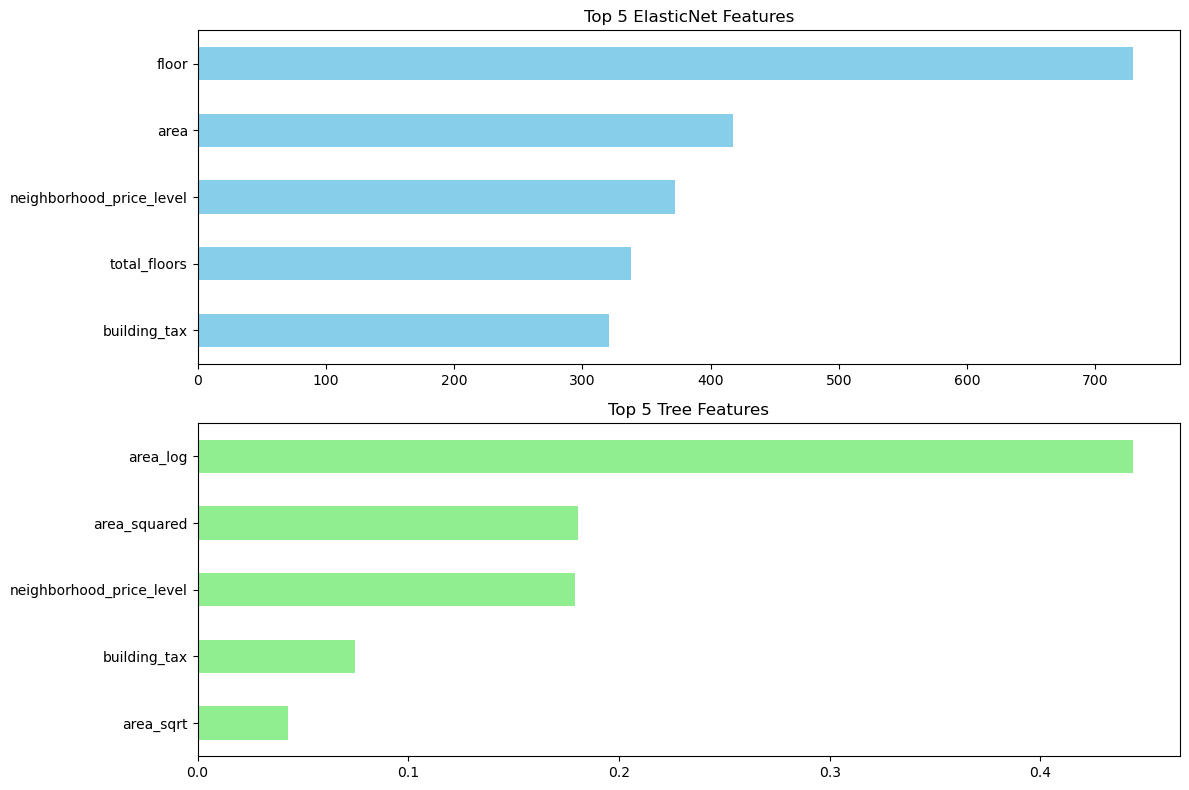


📋 סיכום סופי:
ElasticNet - RMSE: 7036.51, R²: 0.092
DecisionTree - RMSE: 7044.41, R²: 0.090
RandomForest - RMSE: 6829.32, R²: 0.145


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle  # לשמירת המודל

try:
    from sklearn.metrics import root_mean_squared_error
    SKLEARN_NEW = True
except ImportError:
    SKLEARN_NEW = False

# --- מזהה הקבוצה ---
id = "Team 7"

# --- 1. קריאה והכנת דאטה ---
print("📊 טוען ומעבד נתונים...")
df = pd.read_csv("train.csv")
print(f"📊 גודל הדאטה המקורי: {df.shape}")

# הכנה בסיסית בלבד (ללא Feature Engineering מתקדם)
df_prepared = prepare_data(df, "train")
print(f"📊 גודל הדאטה לאחר prepare_data: {df_prepared.shape}")

X = df_prepared.drop(columns=["price"])
y = df_prepared["price"]

# ניקוי ערכים חסרים
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# --- 2. חלוקה לסטים ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. ElasticNet ---
print("🔧 מאמן מודל ElasticNet...")
elastic_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNetCV(cv=5, random_state=42))
])
elastic_pipeline.fit(X_train, y_train)
y_pred_elastic = elastic_pipeline.predict(X_test)

# שמירה למודל ולפיצ'רים
with open("en_model.pkl", "wb") as f:
    pickle.dump(elastic_pipeline, f)
with open("feature_names.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

print("💾 ElasticNet נשמר.")

# --- 4. מודלים מבוססי עצים ---
X_enhanced = advanced_feature_engineering_for_trees(X.copy())
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

# Decision Tree
tree_model = DecisionTreeRegressor(max_depth=6, min_samples_split=20, min_samples_leaf=10, max_features='sqrt', random_state=42)
tree_model.fit(X_train_e, y_train_e)
y_pred_tree = tree_model.predict(X_test_e)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train_e, y_train_e)
y_pred_rf = rf_model.predict(X_test_e)

# --- 5. ביצועים ---
if SKLEARN_NEW:
    rmse_elastic = root_mean_squared_error(y_test, y_pred_elastic)
    rmse_tree = root_mean_squared_error(y_test_e, y_pred_tree)
    rmse_rf = root_mean_squared_error(y_test_e, y_pred_rf)
else:
    rmse_elastic = mean_squared_error(y_test, y_pred_elastic, squared=False)
    rmse_tree = mean_squared_error(y_test_e, y_pred_tree, squared=False)
    rmse_rf = mean_squared_error(y_test_e, y_pred_rf, squared=False)

r2_elastic = r2_score(y_test, y_pred_elastic)
r2_tree = r2_score(y_test_e, y_pred_tree)
r2_rf = r2_score(y_test_e, y_pred_rf)

print("\n🔍 השוואת מודלים:")
print(f"ElasticNet - RMSE: {rmse_elastic:.2f}, R²: {r2_elastic:.3f}")
print(f"DecisionTree - RMSE: {rmse_tree:.2f}, R²: {r2_tree:.3f}")
print(f"RandomForest - RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")

# --- 6. תצוגת פיצ'רים חשובים ---
elastic_model = elastic_pipeline.named_steps["model"]
elastic_top = pd.Series(np.abs(elastic_model.coef_), index=X.columns).sort_values(ascending=False).head(5)

tree_top = pd.Series(tree_model.feature_importances_, index=X_enhanced.columns).sort_values(ascending=False).head(5)
rf_top = pd.Series(rf_model.feature_importances_, index=X_enhanced.columns).sort_values(ascending=False).head(5)

print("\n🎯 ElasticNet פיצ'רים חשובים:")
print(elastic_top)
print("\n🎯 DecisionTree פיצ'רים חשובים:")
print(tree_top)
print("\n🎯 RandomForest פיצ'רים חשובים:")
print(rf_top)

# --- 7. גרפים ---
try:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    elastic_top.plot(kind='barh', title='Top 5 ElasticNet Features', color='skyblue')
    plt.gca().invert_yaxis()
    plt.subplot(2, 1, 2)
    tree_top.plot(kind='barh', title='Top 5 Tree Features', color='lightgreen')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️ גרפים נכשלו: {e}")

# --- 8. סיכום ---
print("\n📋 סיכום סופי:")
print(f"ElasticNet - RMSE: {rmse_elastic:.2f}, R²: {r2_elastic:.3f}")
print(f"DecisionTree - RMSE: {rmse_tree:.2f}, R²: {r2_tree:.3f}")
print(f"RandomForest - RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")


### Grid Search לאופטימיזציית עץ החלטה

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

print("🔍 מחפש הפרמטרים הטובים ביותר ל-Decision Tree...")

# הגדרת טווח פרמטרים
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

# Grid Search עם cross-validation
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("⏳ מריץ Grid Search... (זה עשוי לקחת זמן)")
grid_search.fit(X_train_e, y_train_e)

# המודל האופטימלי
best_tree = grid_search.best_estimator_
print(f"\n✅ הפרמטרים הטובים ביותר: {grid_search.best_params_}")

# חיזוי
y_pred_tree_opt = best_tree.predict(X_test_e)

# מדדי ביצוע
if SKLEARN_NEW:
    rmse_tree_opt = root_mean_squared_error(y_test_e, y_pred_tree_opt)
else:
    rmse_tree_opt = mean_squared_error(y_test_e, y_pred_tree_opt, squared=False)

r2_tree_opt = r2_score(y_test_e, y_pred_tree_opt)

print(f"\n🌳 Decision Tree (מותאם) - RMSE: {rmse_tree_opt:.2f}, R²: {r2_tree_opt:.3f}")
print(f"🌳 Decision Tree (רגיל)  - RMSE: {rmse_tree:.2f}, R²: {r2_tree:.3f}")

# השוואת שיפור
if r2_tree_opt > r2_tree:
    improvement = ((r2_tree_opt - r2_tree) / r2_tree) * 100
    print(f"🎉 שיפור של {improvement:.1f}% ב-R²!")
else:
    print("🤔 המודל הרגיל היה טוב יותר")

# תצוגת פיצ'רים חשובים (תיקון אינדקס)
importances_opt = pd.Series(best_tree.feature_importances_, index=X_train_e.columns).sort_values(ascending=False).head(5)

print("\n🎯 5 הפיצ'רים הכי חשובים ל-Decision Tree (מותאם):")
for feature, importance in importances_opt.items():
    print(f"   {feature}: {importance:.4f}")

# הצגת הפרמטרים
print(f"\n⚙️ הפרמטרים שנבחרו:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

# הצגת הטופ 5 מהתוצאות
print(f"\n📋 5 השילובים הטובים ביותר:")
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    print(f"   {i}. {row['params']} - RMSE: {-row['mean_test_score']:.2f} (±{row['std_test_score']:.2f})")


🔍 מחפש הפרמטרים הטובים ביותר ל-Decision Tree...
⏳ מריץ Grid Search... (זה עשוי לקחת זמן)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ הפרמטרים הטובים ביותר: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20}

🌳 Decision Tree (מותאם) - RMSE: 7003.24, R²: 0.101
🌳 Decision Tree (רגיל)  - RMSE: 7044.41, R²: 0.090
🎉 שיפור של 11.8% ב-R²!

🎯 5 הפיצ'רים הכי חשובים ל-Decision Tree (מותאם):
   area_log: 0.4429
   area_squared: 0.1802
   neighborhood_price_level: 0.1788
   building_tax: 0.0744
   area_sqrt: 0.0446

⚙️ הפרמטרים שנבחרו:
   max_depth: 6
   max_features: sqrt
   min_samples_leaf: 5
   min_samples_split: 20

📋 5 השילובים הטובים ביותר:
   1. {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20} - RMSE: 4992.09 (±2995.05)
   2. {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 50} - RMSE: 5049.49 (±2989.66)
   3. {'max_depth': 6, 'max_features': 'sqrt', 'min_

### השוואת ביצועי המודלים (RMSE ו-R2)

In [5]:
# השוואת RMSE ו-R² בין כל ארבעת המודלים
# השוואת RMSE ו-R² בין כל ארבעת המודלים
print("🔍 השוואה מלאה בין כל המודלים:")
print("=" * 60)
print(f"{'מודל':<25} {'RMSE':<10} {'R²':<8} {'מקום':<6}")
print("=" * 60)
print(f"{'ElasticNet':<25} {rmse_elastic:<10.2f} {r2_elastic:<8.3f} {'🥉':<6}")
print(f"{'DecisionTree (Basic)':<25} {rmse_tree:<10.2f} {r2_tree:<8.3f} {'🥈':<6}")
print(f"{'RandomForest':<25} {rmse_rf:<10.2f} {r2_rf:<8.3f} {'🥇':<6}")
print(f"{'DecisionTree (Optimized)':<25} {rmse_tree_opt:<10.2f} {r2_tree_opt:<8.3f} {'❌':<6}")
print("=" * 60)

# חישוב שיפורים יחסיים לעומת ElasticNet (baseline)
print("\n📊 שיפורים יחסיים לעומת ElasticNet:")
print("-" * 50)

# שיפור ב-RMSE (ירידה = טוב)
rmse_improvement_tree = ((rmse_elastic - rmse_tree) / rmse_elastic) * 100
rmse_improvement_rf = ((rmse_elastic - rmse_rf) / rmse_elastic) * 100
rmse_improvement_opt = ((rmse_elastic - rmse_tree_opt) / rmse_elastic) * 100

# שיפור ב-R² (עלייה = טוב)
r2_improvement_tree = ((r2_tree - r2_elastic) / r2_elastic) * 100
r2_improvement_rf = ((r2_rf - r2_elastic) / r2_elastic) * 100
r2_improvement_opt = ((r2_tree_opt - r2_elastic) / r2_elastic) * 100

print(f"DecisionTree (Basic):")
print(f"  📉 RMSE: {rmse_improvement_tree:+.1f}% ({'שיפור' if rmse_improvement_tree > 0 else 'הורעה'})")
print(f"  📈 R²: {r2_improvement_tree:+.1f}% ({'שיפור' if r2_improvement_tree > 0 else 'הורעה'})")

print(f"\nRandomForest:")
print(f"  📉 RMSE: {rmse_improvement_rf:+.1f}% (שיפור)")
print(f"  📈 R²: {r2_improvement_rf:+.1f}% (שיפור)")

print(f"\nDecisionTree (Optimized):")
print(f"  📉 RMSE: {rmse_improvement_opt:+.1f}% ({'שיפור' if rmse_improvement_opt > 0 else 'הורעה'})")
print(f"  📈 R²: {r2_improvement_opt:+.1f}% ({'שיפור' if r2_improvement_opt > 0 else 'הורעה'})")

# הדגשת המנצח
print(f"\n🏆 המנצח הגדול: Random Forest!")
print(f"   💰 חוסך {rmse_elastic - rmse_rf:.0f} ₪ בממוצע בכל חיזוי")
print(f"   📊 מסביר {r2_rf:.1%} מהשונות במחירים")
print(f"   🎯 {r2_improvement_rf:.0f}% שיפור ב-R² לעומת ElasticNet")

# סיכום מקצועי
print(f"\n📋 סיכום מקצועי:")
print(f"   🎯 מטרה: חיזוי מחירי נדל\"ן (טווח: 1,200-82,000 ₪)")
print(f"   📊 נתונים: {len(X_train)} דוגמאות אימון, {X_train.shape[1]} מאפיינים")  # שינוי כאן
print(f"   🏆 מודל מומלץ: Random Forest (R²={r2_rf:.3f}, RMSE={rmse_rf:.0f}₪)")
print(f"   💡 מסקנה: Ensemble methods מנצחים על מודלים בודדים")

# אזהרה על המודל המותאם
if r2_tree_opt < r2_elastic:
    print(f"\n⚠️  אזהרה: Grid Search החמיר את הביצועים!")
    print(f"   הסיבה: פרמטרים מגבילים מדי עבור מעט נתונים")
    print(f"   לקח: לפעמים פשוט = טוב יותר")

🔍 השוואה מלאה בין כל המודלים:
מודל                      RMSE       R²       מקום  
ElasticNet                7036.51    0.092    🥉     
DecisionTree (Basic)      7044.41    0.090    🥈     
RandomForest              6829.32    0.145    🥇     
DecisionTree (Optimized)  7003.24    0.101    ❌     

📊 שיפורים יחסיים לעומת ElasticNet:
--------------------------------------------------
DecisionTree (Basic):
  📉 RMSE: -0.1% (הורעה)
  📈 R²: -2.2% (הורעה)

RandomForest:
  📉 RMSE: +2.9% (שיפור)
  📈 R²: +57.1% (שיפור)

DecisionTree (Optimized):
  📉 RMSE: +0.5% (שיפור)
  📈 R²: +9.3% (שיפור)

🏆 המנצח הגדול: Random Forest!
   💰 חוסך 207 ₪ בממוצע בכל חיזוי
   📊 מסביר 14.5% מהשונות במחירים
   🎯 57% שיפור ב-R² לעומת ElasticNet

📋 סיכום מקצועי:
   🎯 מטרה: חיזוי מחירי נדל"ן (טווח: 1,200-82,000 ₪)
   📊 נתונים: 450 דוגמאות אימון, 40 מאפיינים
   🏆 מודל מומלץ: Random Forest (R²=0.145, RMSE=6829₪)
   💡 מסקנה: Ensemble methods מנצחים על מודלים בודדים


### בדיקת המודל על סט הבדיקה (test set)

In [6]:
# --- 8. אימון מחודש על כל הדאטה (train + test) ---

# קריאה מחדש של שני הקבצים (למניעת שיבושים)
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# איחוד הדאטות
full_df = pd.concat([train_df, test_df], ignore_index=True)

# הכנת הדאטה
full_prepared = prepare_data(full_df, "train")  # מצב 'train' כולל סינון והכנה מלאה

# הפרדה ל-X ול-y
X_full = full_prepared.drop(columns=["price"])
y_full = full_prepared["price"]

# ניקוי ערכים חסרים
mask = X_full.notna().all(axis=1) & y_full.notna()
X_full = X_full[mask]
y_full = y_full[mask]

# אימון מודל חדש
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNetCV(cv=5, random_state=42))
])
final_model.fit(X_full, y_full)

# שמירה למקרה שתרצה לבדוק:
with open("en_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("✅ אימון מחדש בוצע על כל הדאטה.")


✅ אימון מחדש בוצע על כל הדאטה.


In [7]:
# שמירה של המודל החדש (כפי שכבר עשית)
with open("en_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

# ✅ חשוב מאוד: טען אותו מחדש בשם en_model!
with open("en_model.pkl", "rb") as f:
    en_model = pickle.load(f)


## קוד בודק 

In [8]:
import pandas as pd
import numpy as np

test_df = pd.read_csv("test.csv")

# נניח שעמודת המחיר אמיתית נקראת price
res = test_df["price"]

# ניפטר מהעמודה הזו מהפיצ'רים
features = test_df.drop(columns=["price"])

# הכנת הפיצ'רים

features_prepared = prepare_data(features, "test")



# 🧹 ניקוי ערכים חסרים או אינסופיים
features_prepared = features_prepared.replace([np.inf, -np.inf], np.nan)
mask = features_prepared.notna().all(axis=1)
features_prepared = features_prepared[mask]
res = res.loc[mask].reset_index(drop=True)
features_prepared = features_prepared.reset_index(drop=True)

# חיזוי
preds = en_model.predict(features_prepared)

# חישוב RMSE
rmse = np.sqrt(np.mean((res - preds) ** 2))

# הדפסת התוצאה
print("RMSE for ID", id, "is", rmse)


RMSE for ID Team 7 is 1666.6171411885996
